# Population of Turkey's provinces and Izmir's town
In this projest, population of 81 province in Turkey will be shown as Turkey's map. Chlorap will be used.
Similarly population of İzmir's towns will be shown.
- Population of each province will be taken from excel file.
- populations will be inserted into Turkey's geodataframe from Turkeys province shape file.
- Province names and populations will be placed on the map  

** To Do **  
-Bozuk il isimlerini lookup tablosundan değiştirmek / 20180726  
-Şehir merkezlerini nokta olarak haritaya işlemek  
-Şehir isimlerini haritaya ekle  
-Groupby yıllara göre tabloyu düzenle  
-lejand da aralıkları belirleme

In [2]:
%matplotlib inline

import pandas as pd
import geopandas

# pd.options.display.max_rows = 10

## Maps and shape files
gadm36_TUR_0.shp Turkey in general  
gadm36_TUR_0.shp Turkey/provinces  
gadm36_TUR_0.shp Turkey/towns  
https://gadm.org/index.html shape files can be download.

In [3]:
provinces = geopandas.read_file("data/gadm36_TUR_1.shp", encoding = 'utf-8')
provinces = provinces[['NAME_1','geometry']]
provinces = provinces.rename(columns={'NAME_1': 'province'})

In [36]:
wrong_provinces = {'Afyon':'Afyonkarahisar'}
provinces.replace(wrong_provinces, inplace=True)
provinces.head()

,province,geometry
0,Adana,"(POLYGON ((35.20958328 36.67874908, 35.2095832..."
1,Adıyaman,"POLYGON ((38.68339157 37.60322571, 38.66181564..."
2,Afyonkarahisar,"POLYGON ((30.18260765 37.90116119, 30.18877983..."
3,Ağrı,"POLYGON ((43.71635437 39.37020493, 43.7074585 ..."
4,Aksaray,"POLYGON ((34.39512634 38.19466782, 34.39625931..."


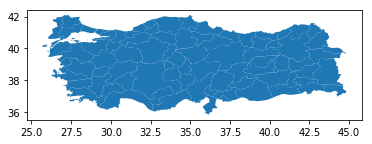

In [176]:
provinces.plot()

Change coordinate system
CRS

## Load population from TUIK data
Read from csv file take from TUIK website https://biruni.tuik.gov.tr/medas/  
-skip 5 rows since they are scrambled from source

In [7]:
df = pd.read_csv("data/turkey_population.csv", sep='|', usecols=["year", "province", "population"]
                , index_col=False, header=None, skiprows=5, encoding = 'utf-8'
                , names=['year', 'province', 'population', 'value'])

There are NaN values on year column so it should ve filled with previous column.  
Last row is added from a empty line is csv so it should be removed

In [8]:
df=df.fillna(method='ffill') # fill NaN with previous row value
df=df[:-1] #remove last row

## Data clean up
- convert year and population to integer
- clean province text / split text for '-' and take the first element

In [9]:
df[['year','population']] = df[['year','population']].astype(int)
df['province']=df['province'].str.split('-',expand=True)[0]

Select year

In [25]:
df_year2017 = df.loc[df['year'] == 2017]
df_year2017.head()

,year,province,population
810,2017,Adana,2216475
811,2017,Adıyaman,615076
812,2017,Afyonkarahisar,715693
813,2017,Ağrı,536285
814,2017,Aksaray,402404


### replace wrong names  
data from shp file has wrong name, so it should be replaced before merged with population data  
data.replace({'very bad': 1, 'bad': 2, 'poor': 3, 'good': 4, 'very good': 5}, inplace=True)

In [37]:
wrong_provinces = pd.read_csv("data/wrong_provinces.csv", sep=',', header=None, index_col=False) # read two column into df
wrong_provinces_dic = dict(zip(wrong_provinces[0], wrong_provinces[1])) # convert df into dictionary
provinces.replace(wrong_provinces_dic, inplace=True) # replace wrong values

### Merge shp dataframe with population

In [35]:
province_pop = pd.merge(provinces, df_year2017, on='province', how='outer')
province_pop.head()

,province,geometry,year,population
0,Adana,"(POLYGON ((35.20958328 36.67874908, 35.2095832...",2017,2216475
1,Adıyaman,"POLYGON ((38.68339157 37.60322571, 38.66181564...",2017,615076
2,Afyonkarahisar,"POLYGON ((30.18260765 37.90116119, 30.18877983...",2017,715693
3,Ağrı,"POLYGON ((43.71635437 39.37020493, 43.7074585 ...",2017,536285
4,Aksaray,"POLYGON ((34.39512634 38.19466782, 34.39625931...",2017,402404


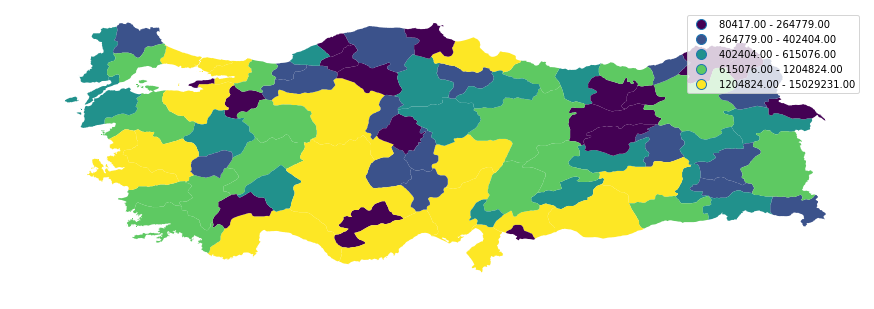

In [33]:
ax = province_pop.plot(figsize=(15, 15), column='population', scheme='quantiles', legend=True)
ax.set_axis_off()

## Analize Data

In [34]:
sum(province_pop['population']) #Turkey's population

80810525

In [52]:
province_rank = province_pop[province_pop['population']>1000000].sort_values(by='population', ascending=0) # provinces over 4 million people
province_rank['Rank'] = df['population'].rank(ascending=1)
province_rank.head()

,province,geometry,year,population,Rank
39,İstanbul,"(POLYGON ((29.11402893 40.82069397, 29.1140289...",2017,15029231,881.0
6,Ankara,"POLYGON ((33.74255371 39.11185455, 33.76644135...",2017,5445026,870.0
40,İzmir,"(POLYGON ((26.88152885 38.02430725, 26.8815288...",2017,4279677,859.0
20,Bursa,"(POLYGON ((28.53902626 40.56708145, 28.5390262...",2017,2936803,848.0
7,Antalya,"(POLYGON ((30.55347252 36.46097183, 30.5534725...",2017,2364396,801.0


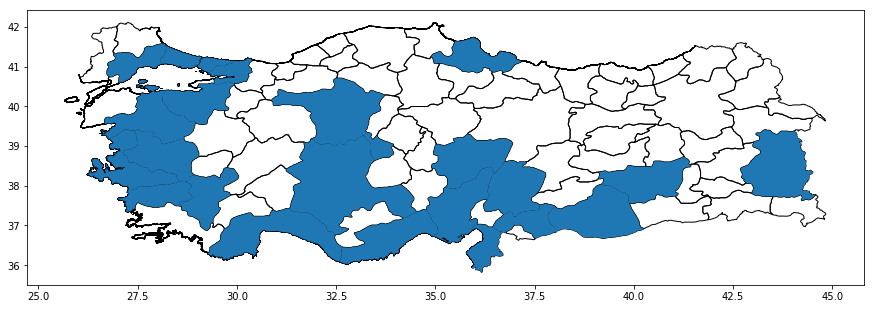

In [55]:
ax = provinces.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
province_rank.plot(ax=ax)

In [ ]:
province_pop.to_csv("data/turkey_population_new.csv", encoding = 'utf-8')